## Overlapping communities

The problem of graph clustering is well studied, in particular the case where the vertices are partitioned into
non-overlapping communities.
We already saw one algorithm, ECG, which is among the best performing algorithms for graph partitioning, and also
provides edge weights (strength of association) based on number of votes. 
Here, we look at the problem of graph clustering where:
* vertices can be part of several communities (overlapping communities)
* vertices can be part of no community ("noise" vertices)

Three methods currently stand out for such problems:
* methods based on finding overlapping cliques (a clique is a complete subgraph)
* methods based on splitting vertices into multiple personae, and
* methods based on clustering the edges.

We illustrate those methods here using the small Karate Club graph, a word association graph and artificial
ABCD benchmark graphs. We also propose some novel improvements inspired by ECG.



## Requirements

* Adjust location of data directory in next cell
* For the last experiment, the following C++ packages need to be installed:
 * LFR benchmark with overlapping communities; download, untar and compile 'binary_networks.tar' from: https://sites.google.com/site/andrealancichinetti/files
 * overlapping NMI measure (oNMI): download and compile from: https://github.com/aaronmcdaid/Overlapping-NMI
* Adjust the location of the executables in the next cell
* also pip install 'omega-index-py3' (ref: https://pypi.org/project/omega-index-py3/)

In [167]:

datadir='../Datasets/'

LFRo = '../../../LFR_Overlap/benchmark' ## overlapping LFR executable
oNMI = '../../../oNMI/onmi'             ## overlapping NMI executable



In [168]:
import igraph as ig
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import adjusted_mutual_info_score as AMI
from itertools import combinations
from IPython.core.display import display, SVG
import time
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import subprocess
import partition_igraph
import os
import omega_index_py3 as omega
import pickle

# CFinder (clique percolation algorithm)

The first algorithm we consider is the Clique Percolation Algorithm, also known as CFinder, which can
be summarized as:
* fix the clique size k (typically k=3 or 4)
* for each k-clique, join all other k-cliques with (k-1) vertices in common, in turn (the percolation)
* continue until all k-cliques are exhausted


In [169]:
def CFinder(g, k=3):
    cls = list(map(set, g.cliques(min=k,max=k)))
    edgelist = []
    for i in range(len(cls)):
        edgelist.append((i,i))
    for i,j in combinations(range(len(cls)),2):
        if len(cls[i].intersection(cls[j])) >= (k-1):
            edgelist.append((i,j))
    cg = ig.Graph(edgelist, directed=False)
    clusters = cg.clusters()
    L = []
    for cluster in clusters:
        members = set()
        for i in cluster:
            members.update(cls[i])
        L.append(set(g.vs[members]["name"]))
    return L


# ECG-based Hierarchical CFinder

We propose to use the ECG-generated edge weights (votes) to obtain a hierarchy of CFinder-generated graphs as follows:
* run ECG and obtain weights (number of votes) for each edge
* rank the edge weights from highest (many votes, strong association) to lowest (no vote, weak association)
* for each weight value, drop edges below this value and run CFinder
* this can be used to look at communities around some given node(s)


In [170]:
## run a sequence of CFinder w.r.t. ECG weights or existing edge weights
## if 'focus' is set, only return communities with this node
## returns a list of lists, the communities
def CFinderECG(g, k=3, focus=None, weighted=False, ens_size=32):
    if weighted:
        g.es['W'] = g.es['weight']
    else:
        ec = g.community_ecg(ens_size=ens_size)
        g.es['W'] = ec.W
    Jumps = np.unique(g.es['W']).tolist()
    Jumps.reverse()
    R = []
    ## loop over 'Jumps'
    for t in Jumps:
        G = g.subgraph_edges([e for e in g.es if e['W']>=t])
        X = CFinder(G, k=k)
        L = [set([g.vs.find(i).index for i in itr]) for itr in X]
        ## keep only 'focus' nodes?
        if focus != None:
            v = g.vs.find(focus).index
            X = [x for x in L if v in x]
            L = X
        if len(L)>0:
            ## see if same as previous
            if len(R)>0:
                x = [i in R[len(R)-1] for i in L] + [i in L for i in R[len(R)-1]]
                if sum(x)<len(x):
                    R.append(L)
            else:
                R.append(L)
    return R
            

### Utility functions to plot the CFinder results

In [171]:
def PlotCFinder(g, L, size=20, outfile=None, col='color', layout=None, margin=15, max_col=None):
    if max_col != None:
        m = max_col
    else:
        m = len(L)
    if col=='color':
        pal = ig.ClusterColoringPalette(n=m)
    else:
        pal = ig.GradientPalette('black','white',m+1)
    g.vs['label'] = g.vs['name']
    g.es['color'] = 'gainsboro'
    ctr = 0
    for l in L:
        for e in g.es:
            if set(e.tuple) <= l:
                e['color'] = pal[ctr]
        ctr += 1
    sg = g.subgraph(set([x for iter in L for x in iter]))
    for v in sg.vs:
        s = set([sg.es[e]['color'] for e in sg.incident(v)])
        if 'gainsboro' in s:
            s.remove('gainsboro')
        if len(s)==1:
            v['color'] = s.pop()
        else:
            v['color'] = 'black'
            v['shape'] = 'square'
    sg.vs['label_color'] = sg.vs['color']
    g.vs['label_color'] = 'gainsboro'
    for v in sg.vs:
        g.vs[g.vs.find(v['name']).index]['label_color'] = v['label_color']
        g.vs[g.vs.find(v['name']).index]['color'] = v['color']
        g.vs[g.vs.find(v['name']).index]['shape'] = v['shape']

    if layout==None:
        layout=g.layout_kamada_kawai()
    if outfile != None:
        ig.plot(g,outfile,bbox=(0,0,1200,800),vertex_size=size,vertex_label_size=0,layout=layout,margin=margin)
    else:
        pl = ig.plot(g,bbox=(0,0,450,300),vertex_size=size,vertex_label_size=0,layout=layout,margin=margin)
        return pl

## reorder 'b' w.r.t. 'a' to keep same comunity colours in successive plots
## unless communities are merged (then one color is kept)
def reorder(a,b):
    x = []
    flag = [0]*len(b)
    for i in a:
        for c in range(len(b)):
            if i <= b[c] and flag[c]==0:
                flag[c]=1
                x.append(b[c])
    for c in range(len(b)):
        if flag[c]==0:
            x.append(b[c])
    return x

    

## CFinder on the Zachary Graph

We illustrate the different CFinder-based algorithms with the well-known Karate Club dataset, which model interaction between 34 members. The 2 communities correspond to groups forming after a split in two "factions". Modularity-based algorithms usually find 4 or 5 communities.
Below, we display the famous Zachary Karate Club dataset, and color the nodes according to the 2 factions after the split.  

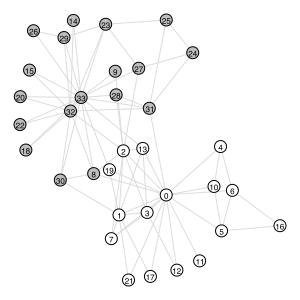

In [172]:
## color with true communities (2 factions)
g = ig.Graph.Read_Ncol(datadir+'Zachary/zachary.edgelist', directed=False)
ly = g.layout_kamada_kawai()
g.vs['size'] = 12
c = np.loadtxt(datadir+'Zachary/zachary.communities', dtype='uint8')
comm = [c[int(x['name'])] for x in g.vs]
cl = ['white','grey']
g.vs['color'] = [cl[i] for i in comm]
g.es['color'] = 'gainsboro'
g.vs['label'] = g.vs['name']
g.vs['shape'] = 'circle'
ig.plot(g,layout=ly, bbox=(0,0,300,300), vertex_label_size = 8, vertex_label_color='black')
#ig.plot(g, 'zachary.eps',layout=ly, bbox=(0,0,600,400), vertex_label_size = 12, 
#        vertex_size=20,vertex_label_color='black')


### The CFinder algorithm

* We run the CFinder algorithm as is on the Karate graph.
* Nodes that belong to 2 or more clusters are represented as squares.
* You can select col='grey' for greyscale, but this is hard to distinguish with several clusters
* we obtain one large community, two small ones and two orphan nodes (in white)

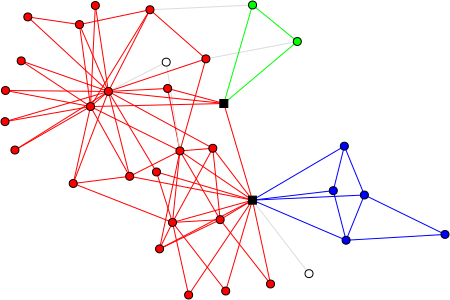

In [173]:
## CFinder communities
g.vs['color'] = 'white'
X = CFinder(g)
L = [set([g.vs.find(i).index for i in itr]) for itr in X]
PlotCFinder(g=g, L=L, layout=ly, size=8, margin=5)
#PlotCFinder(g=g, L=L, outfile='zachary_cf.eps',layout=ly, col='grey')


## Hierarchical CFinder with ECG

ECG induces edge weights from a discrete list of values, since we use a fixed-size ensemble. For each appearing value, we use it as threshold and prune the edges with weight less or equal, in decreasing order. This yields a hierarchy of overlapping clusters, which do not necessarity cover all nodes. The plots are saved as PNG files with the number in the filename indicative of the level in the hierarchy (0-based), for example:

* zachary_cf_0.png: only the srongest edges ar kept 
* zachary_cf_1.png: next stongest
* ...
* zachary_cf_8.png: all is kept except edges with NO vote
* zachary_cf_9.png: same an non-heirarchical CFinder, all is kept

In the above example, there were 10 different thresholds, but this can vary as ECG is stochastic. 
From our experiments, the penultimate result (all edges with at least some vote(s)) gives an interesting view.

* Nodes displayed as black squares belong to 2 or more communities.
* You can select col='grey' for greyscale, but this is hard to distinguish on PNG output or with several clusters

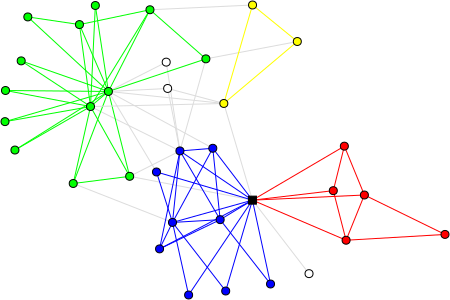

In [174]:
## hierarchical CFinder
C = CFinderECG(g)
m = max([len(x) for x in C])
g.vs['color'] = 'white'
g.vs['shape'] = 'circle'
for i in range(len(C)):
    if i>0:
        C[i] = reorder(C[i-1],C[i])

## plot all in color and save to PNG files
for i in range(len(C)):
    g.vs['shape'] = 'circle'
    PlotCFinder(g=g, L=C[i], outfile='zachary_cf_'+str(i)+'.png', layout=ly, max_col=m)

## plot the penultimate in greyscale
g.vs['color'] = 'white'
g.vs['shape'] = 'circle'
PlotCFinder(g=g, L=C[i-1], layout=ly, max_col=m, margin=5, size=8)
#PlotCFinder(g=g, L=C[i-1], outfile='zachary_cf_ecg.eps', layout=ly, max_col=m, col='grey')


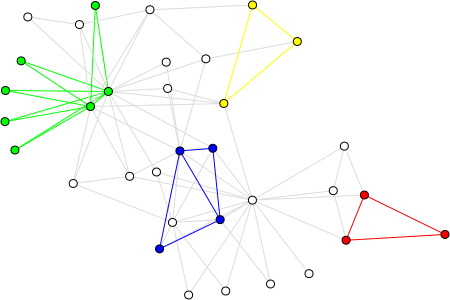

In [183]:
## look at the hierarchy at level l
l = 2
g.vs['color'] = 'white'
g.vs['shape'] = 'circle'
PlotCFinder(g=g, L=C[l], layout=ly, max_col=m, margin=5, size=8)


## Looking around a specific node

* the only difference here is that we select a node and only look at the hierarchy on clusters containing this node. This is an alternative to looking at $k$-hops neighbourhoods for $k \ge 1$.

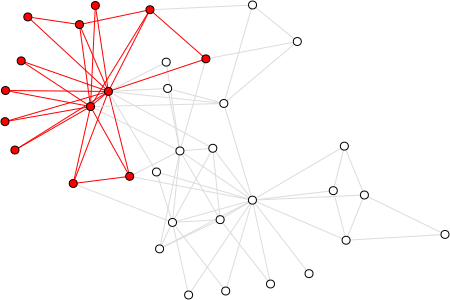

In [25]:
## focus on a single node (see first Zachary plot for node IDs)
node = 8
m = max([len(x) for x in C])
g.vs['color'] = 'white'
g.vs['shape'] = 'circle'
C = CFinderECG(g, focus=str(node))
for i in range(len(C)):
    if i>0:
        C[i] = reorder(C[i-1],C[i])
        
## plot all in color and save to PNG files
for i in range(len(C)):
    g.vs['shape'] = 'circle'
    PlotCFinder(g=g, L=C[i], outfile='zachary_node_'+str(node)+'_cf_'+str(i)+'.png',layout=ly, max_col = m)    

## plot the first or penultimate in greyscale
g.vs['color'] = 'white'
g.vs['shape'] = 'circle'
#PlotCFinder(g=g, L=C[0], layout=ly, max_col=m, margin=5, size=8, col='grey')
PlotCFinder(g=g, L=C[i-1], layout=ly, max_col=m, margin=5, size=8)
#PlotCFinder(g=g, L=C[i-1], outfile='zachary_cf_8_pen.eps', layout=ly, max_col=m, col='grey')      

## CFinder on a Word Association Graph

We consider the graph built from the Word Association dataset (U of South Florida) as described in:

* G. Palla et al, "Uncovering the overlapping structure of complex networks in nature and society", Nature 435, 814-818 (2005).
* raw data at: http://w3.usf.edu/FreeAssociation/Intro.html

In a nutshell, we build a graph with edges between pairs of similar words. We used a threshold of $w*=.025$ for the association strength, treat all edges as unweighted and use $k=4$ for the clique size. We use this dataset to show the usefulness of overlapping clusters to discover various contexts of words.

We also compare methods keeping the edge weights


In [184]:
wg = ig.Graph.Read_Ncol(datadir+'Words/words.txt', names=True, directed=False, weights=True)
wg = wg.simplify(combine_edges="sum") ## sum association strength scores
wg = wg.subgraph_edges([e for e in wg.es if e['weight'] >= .025]) ## prune
wg.vs['label'] = wg.vs['name']
print(wg.vcount(),'nodes and',wg.ecount(),'edges')

5017 nodes and 29266 edges


### Utility function to plot word graph

In [185]:
def PlotCFinderPartial(g, L, size=20, outfile=None, col='color',layout=None, margin=80, max_col=None):
    if max_col != None:
        m = max_col
    else:
        m = len(L)
    if col=='color':
        pal = ig.ClusterColoringPalette(n=m)
    else:
        pal = ig.GradientPalette('black','gainsboro',m)
    g.vs['label'] = g.vs['name']
    g.es['color'] = 'gainsboro'
    ctr = 0
    for l in L:
        for e in g.es:
            if set(e.tuple) <= l:
                e['color'] = pal[ctr]
        ctr += 1
    sg = g.subgraph(set([x for iter in L for x in iter]))
    for v in sg.vs:
        s = set([sg.es[e]['color'] for e in sg.incident(v)])
        if 'gainsboro' in s:
            s.remove('gainsboro')
        if len(s)==1:
            v['color'] = s.pop()
        else:
            v['color'] = 'black'
            v['shape'] = 'square'
    sg.vs['label_color'] = sg.vs['color']
    if outfile != None:
        pl = ig.plot(sg,bbox=(0,0,1200,800),vertex_size=0,vertex_label_size=size,margin=margin)
        pl.save(outfile)
    else:
        pl = ig.plot(sg,bbox=(0,0,500,400),vertex_size=0,vertex_label_size=size,margin=margin)
        return pl


## Some results with ECG-based Hierarchical CFinder

* recall that exact ECG weights may vary between runs, so the hierarchy might differ a little from run to run
* let's look around the work MATH for one of the runs
* other interesting examples include: WORK,DAY,BAD,PLAY,MONEY,GOLD,COUNTRY


In [186]:
word='MATH'
g = wg.copy()
v = g.vs.find(name=word)
n = g.neighborhood(v,order=2)
sg = g.subgraph(n)
C = CFinderECG(sg,k=4,focus=word)
m = max([len(x) for x in C])
for i in range(len(C)):
        if i>0:
            C[i] = reorder(C[i-1],C[i])
        
## plot all in color and save to PNG files
for i in range(len(C)):
    sg.vs['label_color'] = 'black'
    PlotCFinderPartial(g=sg,L=C[i],outfile=word+'_'+str(i)+'.png',max_col=m)


In [187]:
print('number of levels:',len(C))

number of levels: 7


In [188]:
## level-0:
for c in C[0]:
    print([sg.vs[i]['name'] for i in c])

['ALGEBRA', 'CALCULUS', 'TRIGONOMETRY', 'ARITHMETIC', 'MATH']
['MATH', 'ALGEBRA', 'FORMULA', 'EQUATION']


In [189]:
## level-1:
for c in C[1]:
    print([sg.vs[i]['name'] for i in c])

['ALGEBRA', 'CALCULUS', 'TRIGONOMETRY', 'ARITHMETIC', 'MATH']
['MATH', 'ALGEBRA', 'FORMULA', 'EQUATION']
['MATH', 'CALCULATOR', 'CALCULATE', 'COMPUTE']


In [190]:
## level-2:
for c in C[2]:
    print([sg.vs[i]['name'] for i in c])

['ALGEBRA', 'CALCULUS', 'TRIGONOMETRY', 'ARITHMETIC', 'MATH']
['MATH', 'ALGEBRA', 'FORMULA', 'EQUATION']
['CALCULATE', 'COMPUTE', 'FIGURE', 'CALCULATOR', 'MATH']


In [191]:
## penultimate level:
for c in C[-2]:
    print([sg.vs[i]['name'] for i in c])

['ALGEBRA', 'CALCULUS', 'TRIGONOMETRY', 'ARITHMETIC', 'MATH']
['MATH', 'ALGEBRA', 'FORMULA', 'EQUATION']
['COMPUTER', 'CALCULATE', 'COMPUTE', 'FIGURE', 'ADD', 'CALCULATOR', 'MATH']
['DIVISION', 'DIVIDE', 'ADD', 'SUBTRACT', 'MULTIPLY', 'QUOTIENT', 'MATH']


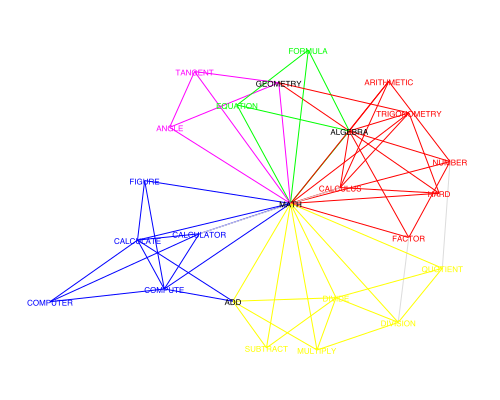

In [193]:
## plot the level-l
l = 6
sg.vs['label_color'] = 'black'
PlotCFinderPartial(g=sg, L=C[l], max_col=m, size=8, margin=50)


### Let's look at the word MONEY

In [194]:
## word MONEY has a lot of depth in terms of communities:
word='MONEY'
g = wg.copy()
v = g.vs.find(name=word)
n = g.neighborhood(v,order=2)
sg = g.subgraph(n)
C = CFinderECG(sg,k=4,focus=word)
m = max([len(x) for x in C])
for i in range(len(C)):
        if i>0:
            C[i] = reorder(C[i-1],C[i])
        
## plot all in color and save to PNG files
for i in range(len(C)):
    sg.vs['label_color'] = 'black'
    PlotCFinderPartial(g=sg,L=C[i],outfile=word+'_'+str(i)+'.png',max_col=m)


In [195]:
## many levels here
print('number of levels:',len(C))

number of levels: 15


In [196]:
## level-0:
for c in C[0]:
    print([sg.vs[i]['name'] for i in c])

['PAY', 'WAGE', 'SALARY', 'MONEY']
['EXPENSE', 'COST', 'PAY', 'MONEY']


In [197]:
## level-1:
for c in C[1]:
    print([sg.vs[i]['name'] for i in c])

['PAY', 'WAGE', 'SALARY', 'MONEY']
['EXPENSE', 'BILL', 'MONEY', 'COST', 'PAY', 'FEE', 'PRICE']
['BILL', 'DUE', 'MONEY', 'DEBT', 'FEE', 'PAYMENT']


In [198]:
## last level:
for c in C[-1]:
    print([sg.vs[i]['name'] for i in c])

['PAY', 'WAGE', 'SALARY', 'MONEY']
['EXPENSIVE', 'EXPENSE', 'BILL', 'AMOUNT', 'MONEY', 'COST', 'PAY', 'FEE', 'PRICE', 'VALUE', 'TOLL', 'WORTH']
['CHECK', 'BILL', 'DUE', 'MONEY', 'DEBT', 'FEE', 'PAYMENT', 'RECEIPT']
['MORTGAGE', 'MONEY', 'LOAN', 'BANK', 'PAYMENT']
['BORROW', 'OWE', 'MONEY', 'LOAN', 'LEND']
['BANKER', 'BANK', 'TELLER', 'MONEY']
['CHECK', 'DEPOSIT', 'MONEY', 'ACCOUNT', 'BANK', 'CHECKING', 'CHECKBOOK']
['BUY', 'SHOPPING', 'SHOP', 'MALL', 'RENT', 'PLAZA', 'MONEY', 'CLOTHES', 'SELL', 'SALE', 'MARKET', 'CHECK', 'PAY', 'CONSUMER', 'STORE', 'PURCHASE', 'SPEND', 'CASH', 'CUSTOMER', 'OWE', 'RECEIPT']
['ECONOMY', 'CHEAP', 'BUDGET', 'MONEY']
['NICKEL', 'QUARTER', 'CHANGE', 'MONEY', 'DOLLAR', 'CENT', 'PENNY', 'DIME', 'COIN', 'CENTS']
['SPEND', 'SAVE', 'MONEY', 'THRIFT']
['EXCHANGE', 'MONEY', 'SELL', 'BARTER', 'TRADE']
['POVERTY', 'WEALTH', 'GOLD', 'FORTUNE', 'LUXURY', 'RICH', 'LIMOUSINE', 'MONEY', 'SUCCEED', 'PROSPER', 'FAME', 'PRESTIGE', 'POWER', 'POOR', 'MANSION', 'SUCCESS']
['OCC

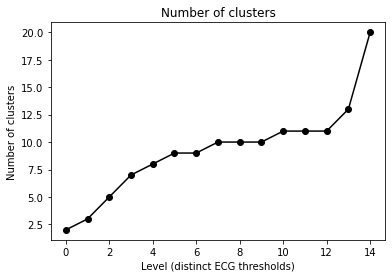

In [200]:
## number of clusters vs threshold
pts = []
for c in C:
    pts.append(len(c))
plt.plot(pts, 'o-',color='black')
plt.title('Number of clusters')
plt.xlabel('Level (distinct ECG thresholds)')
plt.ylabel('Number of clusters');
#plt.savefig('money.eps');

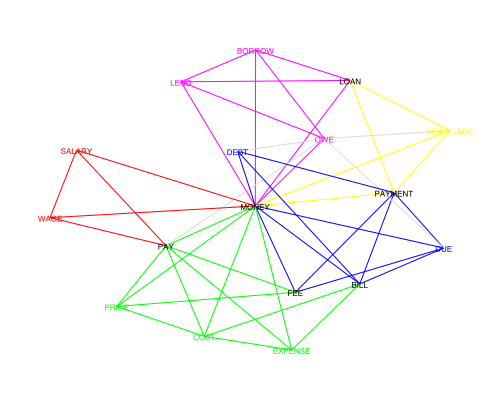

In [201]:
## plot level l
l = 2
sg.vs['label_color'] = 'black'
PlotCFinderPartial(g=sg, L=C[l], max_col=m, size=8, margin=50, col='color')
              

## Hierarchical CFinder using the association strength weights


In [46]:
word='MATH'
g = wg.copy()
v = g.vs.find(name=word)
n = g.neighborhood(v,order=2)
sg = g.subgraph(n)
C = CFinderECG(sg,k=4,focus=word,weighted=True) ## use association scores
m = max([len(x) for x in C])
for i in range(len(C)):
        if i>0:
            C[i] = reorder(C[i-1],C[i])
        
## plot all in color and save to PNG files
for i in range(len(C)):
    sg.vs['label_color'] = 'black'
    PlotCFinderPartial(g=sg,L=C[i],outfile=word+'_'+str(i)+'.png',max_col=m)


In [47]:
print('number of levels:',len(C))

number of levels: 11


In [48]:
## level-0:
for c in C[0]:
    print([sg.vs[i]['name'] for i in c])

['MATH', 'CALCULUS', 'HARD', 'TRIGONOMETRY']


In [49]:
## level-1:
for c in C[1]:
    print([sg.vs[i]['name'] for i in c])

['ALGEBRA', 'CALCULUS', 'HARD', 'TRIGONOMETRY', 'MATH']


In [50]:
## level-2:
for c in C[5]:
    print([sg.vs[i]['name'] for i in c])

['ALGEBRA', 'CALCULUS', 'HARD', 'TRIGONOMETRY', 'MATH']
['CALCULATE', 'COMPUTE', 'FIGURE', 'ADD', 'MATH']
['MATH', 'ALGEBRA', 'FACTOR', 'NUMBER']
['DIVISION', 'DIVIDE', 'ADD', 'SUBTRACT', 'MULTIPLY', 'QUOTIENT', 'MATH']


In [51]:
## level-1:
for c in C[-2]:
    print([sg.vs[i]['name'] for i in c])

['ALGEBRA', 'CALCULUS', 'HARD', 'TRIGONOMETRY', 'GEOMETRY', 'MATH']
['COMPUTER', 'CALCULATE', 'COMPUTE', 'FIGURE', 'ADD', 'CALCULATOR', 'MATH']
['MATH', 'ALGEBRA', 'FACTOR', 'NUMBER']
['DIVISION', 'DIVIDE', 'ADD', 'SUBTRACT', 'MULTIPLY', 'QUOTIENT', 'MATH']
['MATH', 'ANGLE', 'TANGENT', 'GEOMETRY']
['MATH', 'ALGEBRA', 'FORMULA', 'EQUATION']


# 2. Ego-Splitting method

The Ego-Splitting framework was proposed by A. Epasto, S. Lattanzi and R.P. Leme at KDD 2017:

https://www.kdd.org/kdd2017/papers/view/ego-splitting-framework-from-non-overlapping-to-overlapping-clusters


In summary, the steps are:
* For each vertex $v$:
 * build the ego-net for $v$ (minus self)
 * cluster this ego-net using a local method, such as label propagation (LP) or connected components (CC)
 * "split" vertex $v$ into one persona per ego-net cluster
* Cluster this new graph (with duplicated vertices) with some graph partitioning algorithm such as LP or ECG. 
 * We can set a minimum community size to avoid tiny ones.

The original paper uses a LP method based on the Potts model, but we will use the Label Propagation from Raghavan et. al. which is implemented in igraph.


In [202]:
def EgoSplit(G, algo='LP'):
    g = G.copy()
    ## implement ego-split approach with LP+LP and LP+ECG
    g.vs['original'] = g.vs['name']
    ## use the vertex names to avoid issues when vertices are re-mapped ...
    names = g.vs['name']
    ## step 1 - ego-nets and LP communities
    for nm in names:
        v = g.vs.find(nm).index
        n = g.neighbors(v)
        sg = g.subgraph(n)
        x = sg.community_label_propagation().membership
        if np.min(x)==-1:
            x = [i+1 for i in x]
        for j in set(x):
            g.add_vertex(name=nm+'.'+str(j),original=nm)

        l = sg.vs['name']
        for j in range(len(x)):
            g.add_edge(nm+'.'+str(x[j]) , l[j])
        g.delete_vertices(v)
    ## step 2 -- cluster w.r.t. multiple personae
    if algo=='LP':
        cl = g.community_label_propagation()
    else:
        cl = g.community_ecg(ens_size=32)
    C = [set(sg.vs['original']) for sg in cl.subgraphs()]
    return C


In [203]:
def EgoSplitCC(G, algo='LP'):
    g = G.copy()
    ## implement ego-split approach with CC+LP and CC+ECG
    g.vs['original'] = g.vs['name']
    ## use the vertex names to avoid issues when vertices are re-mapped ...
    names = g.vs['name']
    ## step 1 - ego-nets and LP communities
    for nm in names:
        v = g.vs.find(nm).index
        n = g.neighbors(v)
        sg = g.subgraph(n)
        x = sg.clusters().membership
        if np.min(x)==-1:
            x = [i+1 for i in x]
        for j in set(x):
            g.add_vertex(name=nm+'.'+str(j),original=nm)

        l = sg.vs['name']
        for j in range(len(x)):
            g.add_edge(nm+'.'+str(x[j]) , l[j])
        g.delete_vertices(v)
    ## step 2 -- cluster w.r.t. multiple personae
    if algo=='LP':
        cl = g.community_label_propagation()
    else:
        cl = g.community_ecg(ens_size=32)
    C = [set(sg.vs['original']) for sg in cl.subgraphs()]
    return C


### Ego-splitting on the Zachary graph

Using Label Propagation for local ego-net clustering, and Label Propagation (LP) or ECG for the final clustering

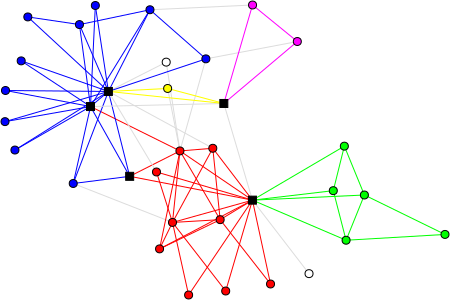

In [217]:
## LP in last step
g = ig.Graph.Read_Ncol(datadir+'Zachary/zachary.edgelist',directed=False)
g.vs['color'] = 'white'
X = EgoSplit(g, algo='LP')
L = [set([g.vs.find(i).index for i in itr]) for itr in X]
C = [set(l) for l in L if len(l)>=3] ## min community size set to 3
PlotCFinder(g=g, L=C, margin=5, size=8)


In [34]:
#PlotCFinder(g=g, L=C, outfile='zachary_ego_lp.eps', layout=ly, col='grey')      

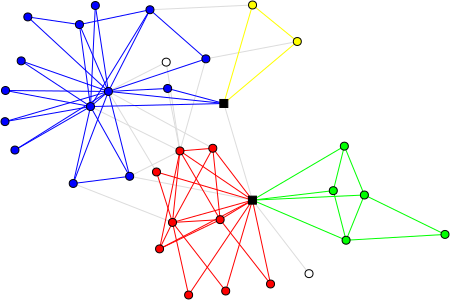

In [205]:
## ECG in last step
g = ig.Graph.Read_Ncol(datadir+'Zachary/zachary.edgelist',directed=False)
g.vs['color'] = 'white'
X = EgoSplitCC(g,algo='ECG')
L = [set([g.vs.find(i).index for i in itr]) for itr in X]
C = [set(l) for l in L if len(l)>=3] ## min community size set to 3
PlotCFinder(g=g, L=C, margin=5, size=8)

In [36]:
#PlotCFinder(g=g, L=C, outfile='zachary_ego_ecg.eps', layout=ly, col='grey')      

# 3. Edge Clustering 

Finally, we can obtain overlapping communities by clustering edges instead of vertices.
The algorithm can be described as follows:
* for each pair of edges sharing a node, say $(i,k)$ and $(j,k)$, compute some similarity measure between the neighborhoods of vertices $i$ and $j$, such as the Jaccard measure
* perform hierarchical clustering on the edges with this similarity matrix

This can be implemented by considering the connected components for the line-graph of the original graph using varying thresholds for the Jaccard measure.
* line graph Lg(G) represents ties between edges of G
* Lg(G) nodes are edges in G
* edges sharing a node in G are linked by an edge in Lg(G)

We can pick the "best" clustering in the hierarchy based on the modularity scores on the line graph.


In [218]:
def Jaccard(a,b):
    x = len(set(a).intersection(set(b)))/len(set(a).union(set(b)))
    return x

def weightedLinegraph(g):
    lg = g.linegraph()
    w=[]
    for edge in range(lg.ecount()):
        A = set(g.es[lg.es[edge].tuple[0]].tuple)
        B = set(g.es[lg.es[edge].tuple[1]].tuple)
        x = list((A-B).union(B-A))
        w.append(Jaccard(g.neighborhood(x[0]),g.neighborhood(x[1])))
    lg.es['weight'] = w
    return lg

def edgeCluster(g, color=False):
    q = -999
    D = weightedLinegraph(g)
    for th in sorted(set(D.es['weight'])):
        ## filter edges w.r.t. similarity and find CC
        dg = D.copy()
        dg.delete_edges([e for e in dg.es if e['weight']<=th])
        cc = dg.clusters().membership
        mod = D.modularity(cc)
        if mod>q:
            q = mod
            g.es['lc'] = cc
            if color:
                pal = ig.ClusterColoringPalette(n=max(cc)+1)
                for e in g.es:
                    e['color'] = pal[e['lc']]
    ## Now gather the nodes for each edge cluster
    L = []
    for i in range(max(g.es['lc'])+1):
        sg = g.subgraph_edges([e for e in g.es if e['lc']==i])
        L.append(sg.vs['name'])
    return L

### Edge clustering on the Zachary graph


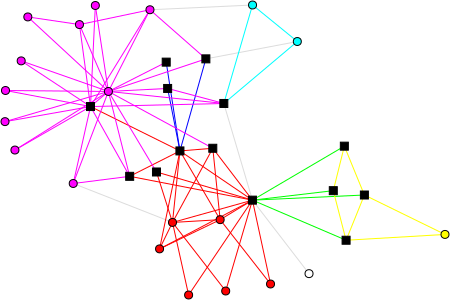

In [219]:
g = ig.Graph.Read_Ncol(datadir+'Zachary/zachary.edgelist',directed=False)
g.vs['color'] = 'white'
X = edgeCluster(g)
L = [set([g.vs.find(i).index for i in itr]) for itr in X]
C = [set(l) for l in L if len(l)>=3]
PlotCFinder(g=g, L=C, margin=5, size=8)

In [39]:
#PlotCFinder(g=g, L=C, outfile='zachary_edges.eps', layout=ly, col='grey')      

# Study over benchmark graphs

We compare all methods we presented over "LFR with overlaps" benchmark graphs, with varying noise parameter $\mu$. In order to compare the (possibly) overlapping clusters with the ground truth, we use "oNMI", a modification of NMI that can handle overlapping communities, and the Omega index, a variation of the Rand index.

This may take a several minutes as we do several repeats for a range of $\mu$ values


In [220]:
## Reformat -- from LFR_overlap communities to 1 community per line
def mapLFRcommunity(infile=None,outfile=None):
    fn = infile
    with open(fn) as f:
        content = f.readlines()
    f.close()
    content = [x.strip() for x in content] 
    L = []
    for line in content:
        x = line.split('\t')[1]
        y = x.split(' ')
        L.append([int(i) for i in y])
    m = np.max([item for sublist in L for item in sublist])
    C = [[] for i in range(m)]
    for i in range(len(L)):
        for j in L[i]:
            C[j-1].append(i+1)
    import  csv
    fn = outfile
    with open(fn,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(C)
    f.close()
    return C

## get communities and compute oNMI
def oNMIrun(L, min_size=3, comm='./_communities', fn='./_temp'):
    C = [l for l in L if len(l) >= min_size]
    with open(fn,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(C)
    f.close()   
    x = float(subprocess.check_output([oNMI,comm,fn]).decode("utf-8").split()[1])
    return x

## compute Omega index vs GT
def omegaIndex(L, min_size=3, gt='./_communities'):
    s1 = {}
    C = [l for l in L if len(l) >= min_size]
    for i in range(len(C)):
        s1[str(i)] = list(C[i])
    ## ground truth
    lines = [line.rstrip('\n') for line in open(gt)]
    s2 = {}
    for i in range(len(lines)):
        x = [j for j in lines[i].split(' ')]
        s2[str(i)] = x
    return omega.Omega(s1,s2).omega_score

In [152]:
MUs = np.arange(5,71,5) ## range of mu's

In [221]:
## save D as pickle object 
#pickle.dump( D, open( datadir+"Overlap/lfr_100.pkl", "wb" ) )

## load experiment results in D
D = pickle.load(open(datadir+"Overlap/lfr_100.pkl","rb"))


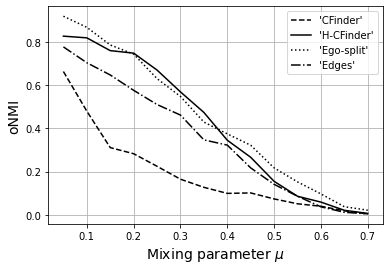

In [224]:
M = D.groupby(by=['mu','algo']).mean()
algo = ["'CFinder'","'H-CFinder'","'Ego-split'","'Edges'"]
#algo = ["'CFinder'","'H-CFinder'","'egoECG'","'Edges'"]
ltyp = ['--','-',':','-.']
for a in range(len(algo)):
    y = [float(x) for x in list(M.query('algo =='+algo[a])['oNMI'])]
    plt.plot([i/100 for i in MUs],y,label=algo[a],linestyle=ltyp[a],color='black')
plt.legend()
plt.xlabel(r'Mixing parameter $\mu$',fontsize=14)
plt.ylabel('oNMI',fontsize=14)
plt.grid();
#plt.savefig('overlap_onmi.eps');

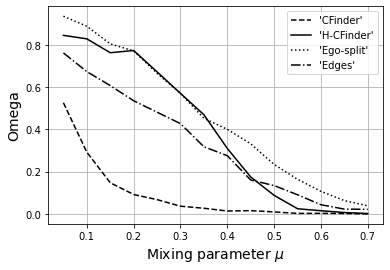

In [225]:
for a in range(len(algo)):
    y = [float(x) for x in list(M.query('algo =='+algo[a])['Omega'])]
    plt.plot([i/100 for i in MUs],y,label=algo[a],linestyle=ltyp[a],color='black')
plt.legend()
plt.xlabel(r'Mixing parameter $\mu$',fontsize=14)
plt.ylabel('Omega',fontsize=14)
plt.grid();
#plt.savefig('overlap_omega.eps');

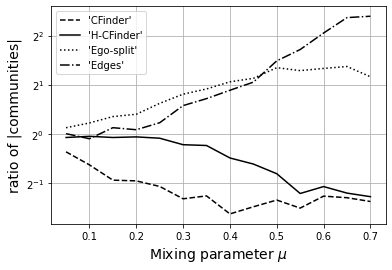

In [226]:
algo = ["'CFinder'","'H-CFinder'","'Ego-split'","'Edges'"]

for a in range(len(algo)):
    y = [float(x) for x in list(M.query('algo =='+algo[a])['delta(n_comm)'])]
    plt.semilogy([i/100 for i in MUs],y,label=algo[a],linestyle=ltyp[a],color='black',base=2)
plt.legend()
#plt.hlines(0,0.05,.7,linestyles=':',color='black')
plt.xlabel(r'Mixing parameter $\mu$',fontsize=14)
plt.ylabel('ratio of |communities|',fontsize=14)
plt.grid();
#plt.savefig('overlap_n-comm.eps');

In [89]:
## save D as pickle object ...
#pickle.dump(D, open( datadir+"Overlap/lfr_250.pkl", "wb" ) )

## or load experiment results in D
D = pickle.load(open(datadir+"Overlap/lfr_250.pkl","rb"))


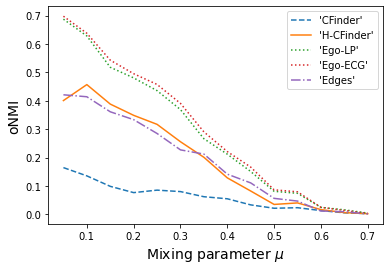

In [90]:
M = D.groupby(by=['mu','algo']).mean()
algo = ["'CFinder'","'H-CFinder'","'Ego-LP'","'Ego-ECG'","'Edges'"]
ltyp = ['--','-',':',':','-.']
for a in range(len(algo)):
    y = [float(x) for x in list(M.query('algo =='+algo[a])['oNMI'])]
    plt.plot([i/100 for i in MUs],y,label=algo[a],linestyle=ltyp[a])
plt.legend()
plt.xlabel(r'Mixing parameter $\mu$',fontsize=14)
plt.ylabel('oNMI',fontsize=14);
#plt.savefig('overlap_onmi_250.eps');

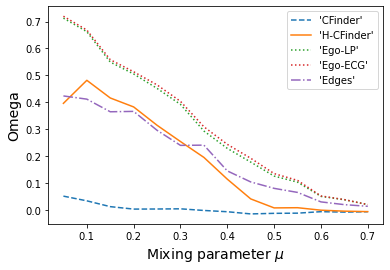

In [91]:
for a in range(len(algo)):
    y = [float(x) for x in list(M.query('algo =='+algo[a])['Omega'])]
    plt.plot([i/100 for i in MUs],y,label=algo[a],linestyle=ltyp[a])
plt.legend()
plt.xlabel(r'Mixing parameter $\mu$',fontsize=14)
plt.ylabel('Omega',fontsize=14);
#plt.savefig('overlap_omega_250.eps');

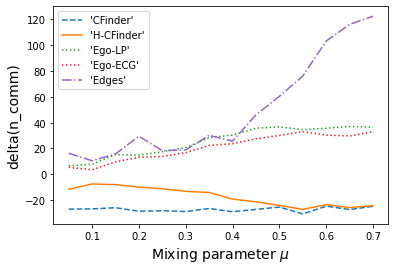

In [92]:
for a in range(len(algo)):
    y = [float(x) for x in list(M.query('algo =='+algo[a])['delta(n_comm)'])]
    plt.plot([i/100 for i in MUs],y,label=algo[a],linestyle=ltyp[a])
plt.legend()
#plt.hlines(0,0.05,.7)
plt.xlabel(r'Mixing parameter $\mu$',fontsize=14)
plt.ylabel('delta(n_comm)',fontsize=14);
#plt.savefig('overlap_n-comm_250.eps');

### Notes

* ego-net based method gives better results than CFinder or edge clustering
* using ECG to and keeping penultimate level in Hierarchical-CFinder helps a lot
* using ECG improves ego-net method slightly over LP

## Measures

Comparing oNMI and Omega measures for random partitions


In [93]:
## generate LFR-overlap graph
#cmd = LFRo+' -N 1000 -k 10 -maxk 50 -minc 10 -maxc 100 -on 100 -om 2 -mu .25'
cmd = LFRo+' -N 1000 -k 10 -maxk 50 -minc 10 -maxc 100 -mu .25'
x = os.system(cmd)
## map resulting communities to proper format for oNMI
x = mapLFRcommunity('./community.dat','./_communities')
nc = len(x)
## build the graph
g = ig.Graph.Read_Ncol('./network.dat',directed=False)
g = g.simplify()
print('number of communities:',len(x))

number of communities: 20


In [94]:
## random partition with r parts: 1000 nodes, 100 in 2 communities
mc = 5  ## min comm size
X = []
for r in np.arange(2,61,2):
    #n = [str(i) for i in np.arange(1,1001)]+[str(i) for i in np.arange(1,101)]
    n = [str(i) for i in np.arange(1,1001)]
    rc = np.random.choice(r,len(n))
    L = [set() for i in range(r)]
    for i in range(len(n)):
        L[rc[i]].add(n[i])
    X.append([r,oNMIrun(L,min_size=mc),omegaIndex(L,min_size=mc)])
D = pd.DataFrame(X,columns=['comms','oNMI','Omega'])

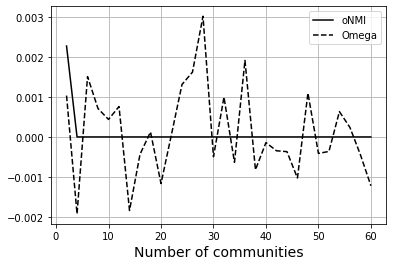

In [95]:
x = np.arange(2,61,2)
plt.plot(x,D['oNMI'],label='oNMI',linestyle='-',color='black')
plt.plot(x,D['Omega'],label='Omega',linestyle='--',color='black')
plt.legend()
plt.grid()
plt.xlabel('Number of communities',fontsize=14);
#plt.savefig('measures_bias.eps');
